## Using Versatile Behavior Diffusion (VBD) with GPUDrive

---

> [VBD project page](https://sites.google.com/view/versatile-behavior-diffusion?pli=1) | [ArXiv](https://arxiv.org/abs/2404.02524)

---

In this notebook we demonstrate how you can generate realistic vehicle trajectories with VBD.

In [17]:
# Dependencies
import os
from pathlib import Path
import torch
import warnings
import mediapy
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange
warnings.filterwarnings("ignore")

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

from pygpudrive.env.config import EnvConfig, RenderConfig, SceneConfig, SelectionDiscipline
from pygpudrive.env.env_torch import GPUDriveTorchEnv

# Plotting
sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (8, 3)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel("WARNING")

In [18]:
"""Helper functions for sanity checks (will be removed)."""

def plot_batch_distributions(batch, dist_type='hist'):

    num_keys = len(batch.keys())
    num_cols = 3
    num_rows = math.ceil(num_keys / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    fig.suptitle("Distribution of each batch -> f(batch) -> pred", y=1.02)
    axes = axes.flatten()

    for i, key in enumerate(batch.keys()):
        data = batch[key].cpu().numpy().flatten()
        
        if dist_type == 'hist':
            axes[i].hist(batch[key].cpu().numpy().flatten(), bins=30)
        elif dist_type == 'box_plot':
            
            sns.boxplot(data=data, ax=axes[i], width=0.3)
            # Add a strip plot to visualize individual data points
            sns.stripplot(data=data, ax=axes[i], color='k', size=3, jitter=True)
        
        max_value = data.max()
        min_value = data.min()
        axes[i].set_title(f"{key}: Min={min_value:.2f}, Max={max_value:.2f}")
        axes[i].set_xlabel("Value")
        axes[i].set_ylabel("Count")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()

## Configuration

 - We only control valid agents up to a maximum of 32
- The initialization steps: 10
- We use the `StateDynamics` model
    - this model has a 5D action `(x, y, yaw, velocity x, velocity y)`

In [19]:
INIT_STEPS = 10
NUM_ENVS = 1

scene_config = SceneConfig(
    path="data/interactive", 
    num_scenes=NUM_ENVS,
    discipline=SelectionDiscipline.K_UNIQUE_N,
    k_unique_scenes=1,
)

env_config = EnvConfig(
    init_steps=INIT_STEPS, # Warmup period
    enable_vbd=True, # Use VBD
    dynamics_model="state", # Use state-based dynamics model
)

render_config = RenderConfig(
    draw_obj_idx=True,
    render_init=True,
)

## Make environment


In [20]:
env = GPUDriveTorchEnv(
    config=env_config,
    scene_config=scene_config,
    render_config=render_config,
    max_cont_agents=32, # Maximum number of agents to control per scene
    device="cpu",
    action_type="continuous",
)

: 

In [5]:
# Sanity check: We have a warmup period of 10 steps, so the first step should be 11
env.reset();
env.step_in_episode

selected_agents = torch.nonzero(env.cont_agent_mask[0, :]).flatten().tolist()

print(f"Selected agents: {selected_agents}")

2024-09-27 17:27:27.052454: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 17:27:27.072273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 17:27:27.508689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


0 0
1 15
2 5
3 1
4 18
5 19
6 17
Selected agents: [6, 7, 8, 18, 19]


### Sanity check: Show the initialization logs

In [6]:
len(env.init_frames)

10

In [7]:
mediapy.show_video(images=env.init_frames, title=f'First {INIT_STEPS} steps, initialization with logged trajectories', width=500, loop=False)

Scenario at t = 10

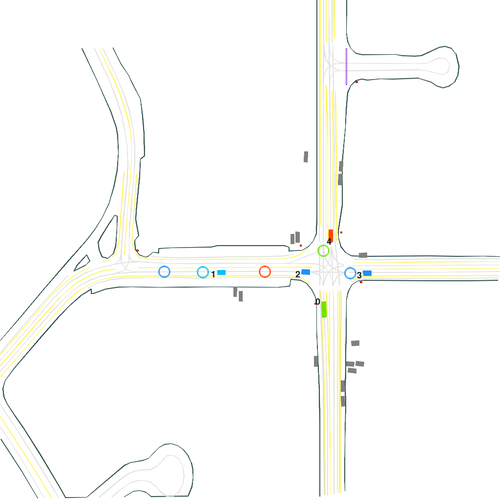

In [8]:
mediapy.show_image(image=env.render(), title=f"Scenario at t = {env.step_in_episode}", width=500)

## Load trained VBD model

In [9]:
# Load model
from vbd.sim_agent.sim_actor import VBDTest

ckpt_path = 'vbd/weights/epoch=18.ckpt'

model = VBDTest.load_from_checkpoint(ckpt_path, map_location=torch.device('cpu'))
_ = model.cuda()
_ = model.eval()

## Rollout without goal guidance

In [10]:
# Get batch of data for VBD model
sample_batch = env.warmup_trajectory

In [11]:
sample_batch.keys()

dict_keys(['agents_history', 'agents_interested', 'agents_type', 'agents_future', 'traffic_light_points', 'polylines', 'polylines_valid', 'relations', 'agents_id', 'anchors'])

Uncomment to check all input distributions

torch.Size([1, 256, 30, 5])


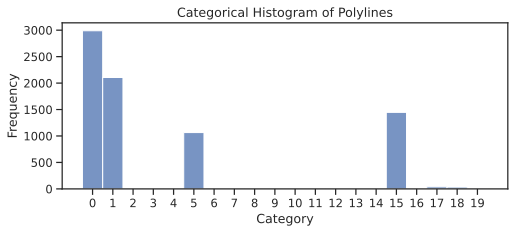

In [13]:
# See: https://github.com/waymo-research/waymax/blob/main/waymax/datatypes/roadgraph.py
print(sample_batch['polylines'].shape)

data = sample_batch["polylines"][:, :, :, -1].flatten().cpu().numpy()

# Create a histogram with discrete categories
sns.histplot(data, bins=20, discrete=True)

# Add labels and title for clarity
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.title("Categorical Histogram of Polylines")
plt.xticks(range(20));  # Ensure x-ticks show integers 0-19;

In [14]:
#plot_batch_distributions(sample_batch, dist_type='box_plot')

In [15]:
replan_freq=80 # Roll out every X steps 80 means openloop
model.early_stop=0 # Stop Diffusion Early From 100 to X
model.skip = 1 # Skip Alpha 
model.reward_func = None

# Reset the environment
init_state = env.reset()

current_state = init_state

# Obtain all info for diffusion model (warmup)
sample_batch = env.warmup_trajectory

# Make a prediction
pred = model.sample_denoiser(sample_batch)#, x_t=x_t)
vbd_traj_pred = pred['denoised_trajs'].cpu().numpy()[0]

is_controlled = sample_batch['agents_interested'] > 0

# TODO: Hacky but needs to be done because our sim expects a 10D action
# (x, y, z, yaw, vel x, vel y, vel z, ang_vel_x, ang_vel_y, ang_vel_z)
# (0, 1, 2, 3,     4,   5,    6,        7,         8,         9)

log_playback_traj = env.get_expert_actions()
pred_trajs = log_playback_traj[:, :, INIT_STEPS+1:, :].clone().squeeze(0)
pred_trajs[:, :, 0:2] = torch.Tensor(vbd_traj_pred[:, :, 0:2]) # pos x, y
pred_trajs[:, :, 3] = torch.Tensor(vbd_traj_pred[:, :, 2]) # yaw 
pred_trajs[:, :, 4:6] = torch.Tensor(vbd_traj_pred[:, :, 3:5]) # vel x, y
pred_trajs = pred_trajs.unsqueeze(0)

# Step with diffussion trajectories
frames = {f"env_{i}": [] for i in range(NUM_ENVS)}

print(f'Rolling out from {env.step_in_episode} to {env_config.episode_len} steps')

for t in trange(int(env_config.episode_len-(INIT_STEPS+1))):
    
    env.step_dynamics(pred_trajs[:, :, t, :])

    for i in range(NUM_ENVS):
        frames[f"env_{i}"].append(env.render(i))

0 0
1 15
2 5
3 1
4 18
5 19
6 17


Diffusion: 100%|██████████| 50/50 [00:01<00:00, 35.73it/s]

Rolling out from 10 to 91 steps


  0%|          | 0/80 [00:00<?, ?it/s]

In [16]:
mediapy.show_videos(frames, fps=30, width=600, height=400, columns=1)

### Todo: Show generated trajectories without goal guidance

In [ ]:
# Takes a list of frames of shape (H, W, 3) and displays them as a video
mediapy.show_video(frames, fps=10)